#Some NLP: Probabilistic Context Free Grammar (PCFG) and CKY Parsing

This problem appeared as an assignment in the **coursera course Natural Language Processing (by Stanford) in 2012**. The following description of the problem is taken directly from the assignment description.

In this article, a **probabilistic parser** will be built by implementing the **CKY parser**. The *Manually Annotated Sub-Corpus* (**MASC**) from the American National Corpus (ANC): http://www.anc.org/MASC/Home.html will be used for this purpose.

In [5]:
#ipython nbconvert pcaiso.ipynb
%matplotlib inline

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

##Instruction

First, we need to learn a **PCFG** from the *training trees*. Since the *training set* is handparsed this learning is very easy. We need to simply set: $$P(N_j \rightarrow \zeta)=\frac{C(N_j \rightarrow \zeta)}{\sum\limits_{\gamma} C(N_j \rightarrow \gamma)}$$ where $C(N_j \rightarrow \zeta)$ is the *count* observed for that *production* in the data set. While we could consider *smoothing rule rewrite probabilities*, it is sufficient to just work with *unsmoothed* **MLE probabilities** for *rules*. (Doing anything else makes things rather more complex and slow, since every rewrite will have a nonzero probability, so let's get things working with an unsmoothed grammar before considering adding smoothing!).

The following figure shows couple of **POS-tagged** training trees from which we need to learn the probabilities for the rules corresponding to the **PCFG** grammar. 

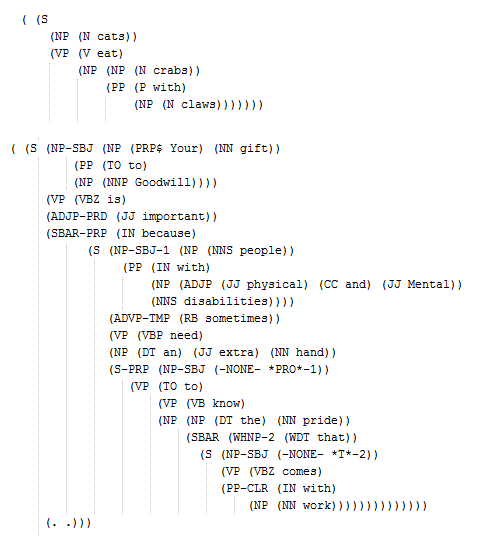

In [4]:
from IPython.display import Image
Image(filename='C:\\courses\\coursera\\Past\\NLP\\Stanford_NLP\\Assignment\\pa6-cky-v2\\python\\train.png')

At the very beginning, all the train and the test trees are read in. The training trees are going to be used to construct a
**PCFG** parser, by learnign the **PCFG grammar**. The parser is then used to predict trees for the sentences in the test set. For each test sentence, the parse given by the parser is evaluated by comparing the constituents it generates with the constituents in the hand-parsed version. From this, *precision*, *recall* and the *F1 score* are calculated.

There are the following basic classes:

• ling.Tree: CFG tree structures (pretty-print with ling.Trees.PennTreeRenderer)

• Lexicon: Pre-terminal productions and probabilities

• Grammar, UnaryRule, BinaryRule: CFG rules and accessors

Most parsers require grammars in which the rules are *at most binary* branching. Hence, first we need to **binarize** the trees and then construct a **Grammar** out of them using **MLE**.

## The Task

The first job is to build a **CKY parser** using this **PCFG grammar** learnt. Scan through a few of the training trees in the MASC dataset to get a sense of the range of inputs. Something worth noticing is that the grammar has relatively few **non-terminal** symbols but **thousands of rules**, many ternary-branching or longer. Currently there are **38 MASC train** files and **11 test** files. 

Once we have a parser working on the treebank, the next task is improve upon the supplied grammar
by adding 1st / 2nd-order **vertical markovization**. This means using parent annotation symbols like NP^S to
indicate a subject noun phrase instead of just NP. 

## Evaulation

For this assignment we will use your **average F1 score** to evaluate the correctness of the **CKY parser**, although in essence we ought to know from the output on the *development set* (**devtest**) whether the parser is implemented correctly.

The following figure shows the **CKY** algorithm to compute the *best possible* (**most probable**) parse tree for a sentence using the **PCFG grammr** learnt from the training dataset. 

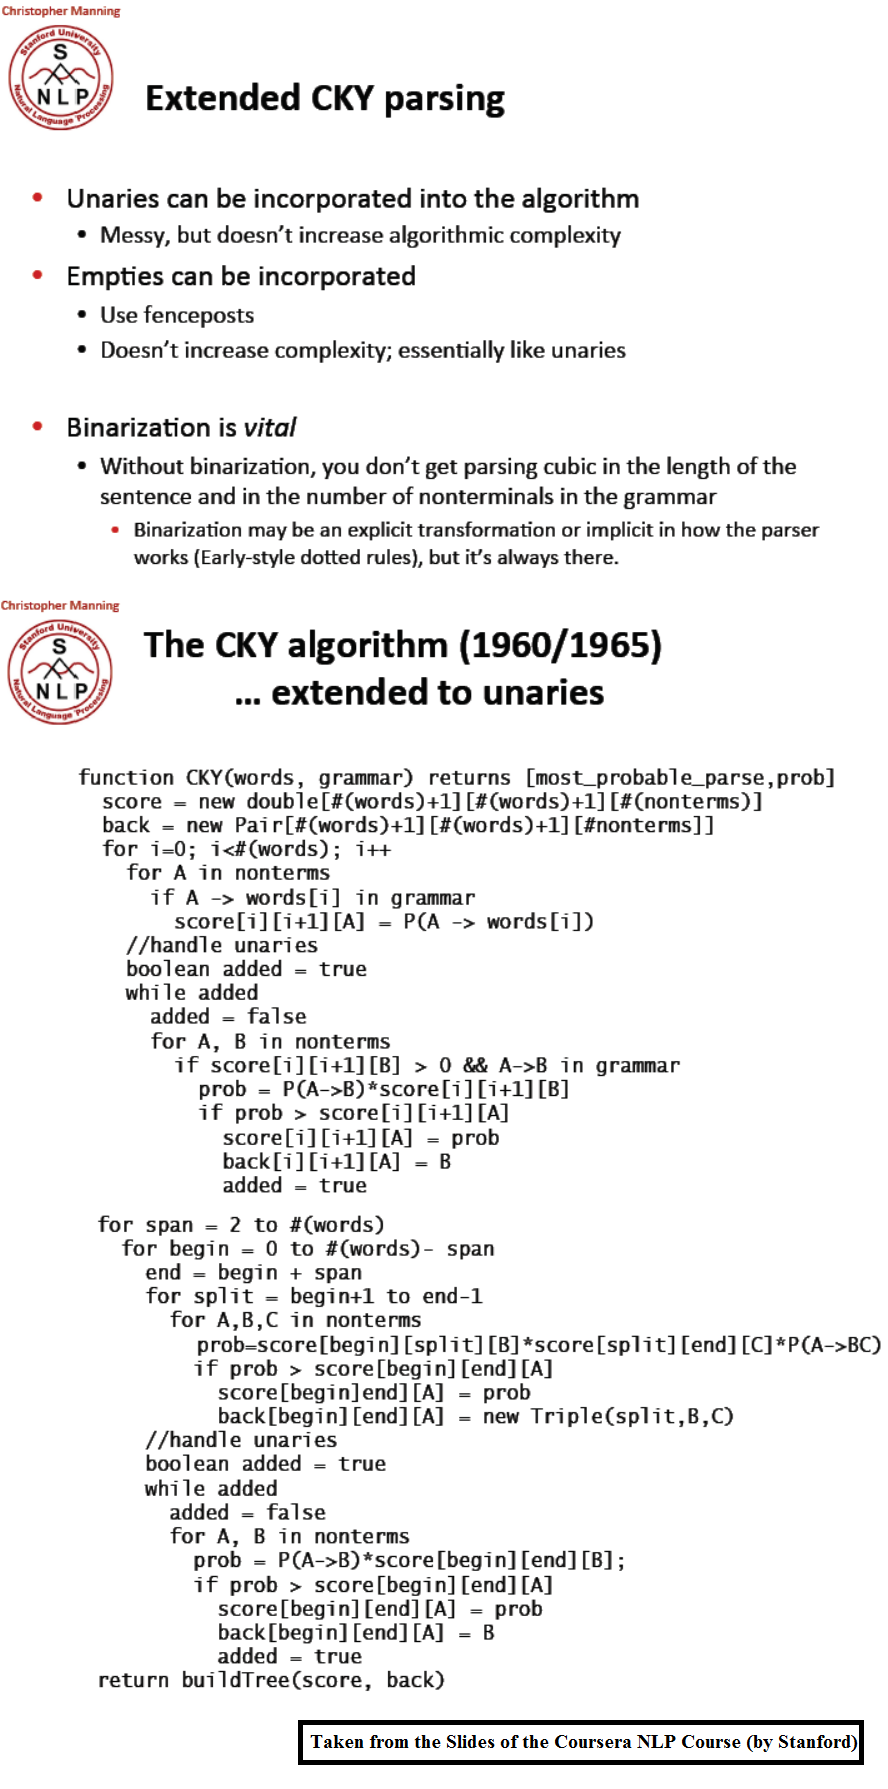

In [6]:
Image(filename='C:\\courses\\coursera\\Past\\NLP\\Stanford_NLP\\Assignment\\pa6-cky-v2\\python\\im0.png')

The following animation (prepared from the lecture slides of the same course) shows how the chart for *CKY* is constructed.

In [26]:
Image(filename='C:\\courses\\coursera\\Past\\NLP\\Stanford_NLP\\Assignment\\pa6-cky-v2\\python\\im1.gif')

ValueError: Cannot embed the 'gif' image format

In [5]:
class Constituent:

    def __init__(self, label, start, end):
        self.label = label
        self.start = start
        self.end = end

    def __eq__(self, o):
        if self is o:
            return True

        if not isinstance(o, Constituent):
            return False

        if (self.end != o.end):
            return False
        if (self.start != o.start):
            return False
        if (self.label != o.label):
            return False

        return True

    def __hash__(self):
        result = hash(self.label)
        result = 29 * result + self.start
        result = 29 * result + self.end
        return result

In [6]:
#from Constituent import Constituent

class Tree:

    # TODO: deepCopy() ?

    def __init__(self, label, children = []):
        """
        The constructor.
        """
        self.label = label
        self.children = children

    def is_leaf(self):
        """
        Returns true at the word (leaf) level of a tree.
        """
        return len(self.children) == 0

    def is_preterminal(self):
        """
        Returns true level of non-terminals which are directly above
        single words (leaves).
        """
        return len(self.children) == 1 and self.children[0].is_leaf()

    def is_phrasal(self):
        return not (self.is_leaf() and self.is_preterminal)

    def _append_yield(self, leaf_labels):
        if self.is_leaf():
            leaf_labels.append(self.label)
            return
        for child in self.children:
            child._append_yield(leaf_labels)

    def get_yield(self):
        """
        Returns a list of words at the leaves of this tree gotten by
        traversing from left to right.
        """
        leaf_labels = []
        self._append_yield(leaf_labels)
        return leaf_labels

    def _append_preterminal_yield(self, preterm_yield):
        if self.is_preterminal():
            preterm_yield.append(self.label)
            return
        for child in self.children:
            child._append_preterminal_yield(preterm_yield)

    def get_preterminal_yield(self):
        """
        Returns a list of the preterminals gotten by traversing from left
        to right.  This is effectively an POS tagging for the words that
        tree represents.
        """
        preterm_yield = []
        self._append_preterminal_yield(preterm_yield)
        return preterm_yield

    def _traversal_helper(self, traversal, pre_order):
        if pre_order:
            traversal.append(self)
        for child in self.children:
            child._traversal_helper(traversal, pre_order)
        if not pre_order:
            traversal.append(self)

    def get_preorder_traversal(self):
        """
        Returns a list of the node values gotten by traversing in this
        order: root, left subtree, right subtree.
        """
        traversal = []
        self._traversal_helper(traversal, True)
        return traversal

    def get_postorder_traversal(self):
        """
        Returns a list of the node values gotten by traversing in this
        order: left subtree, right subtree, root.
        """
        traversal = []
        self._traversal_helper(traversal, False)
        return traversal

    def _set_words_helper(self, words, word_num):
        if self.is_leaf():
            self.label = words[word_num]
            return word_num + 1
        else:
            for child in self.children:
                word_num = child._set_words_helper(words, word_num)
            return word_num

    def set_words(self, words):
        """
        Set the words at the leaves of a tree to the words from the list.
        """
        self._set_words_helper(words, 0)

    def to_subtree_list(self):
        return self.get_preorder_traversal()

    def _to_constituent_helper(self, start, constituents):
        if self.is_leaf() or self.is_preterminal():
            return 1
        span = 0
        for child in self.children:
            span += child._to_constituent_helper(start + span, constituents)
        constituents.append(Constituent(self.label, start, start + span))
        return span

    def to_constituent_list(self):
        """
        Creates a list of all constituents in this tree.  A constituent
        is just a non-terminal label and that non-terminal covers in the
        tree.
        """
        constituent_list = []
        self._to_constituent_helper(0, constituent_list)
        return constituent_list

    def _to_string(self, s):
        if not self.is_leaf():
            s.append('(')
        s.append(self.label)
        if not self.is_leaf():
            for child in self.children:
                s.append(' ')
                child._to_string(s)
            s.append(')')

    def __unicode__(self):
        s = []
        self._to_string(s)
        return ''.join(s)

    def __str__(self):
        return unicode(self).encode('utf-8')

In [7]:
#from Tree import Tree

# TODO: should I replace rendering of tree.label to str(tree.label)??

##################
# Class Methods
##################
ROOT_LABEL = "ROOT"


class TreeTransformer:
    """
    Abstract base class for different Tree transformation classes.
    """
    @classmethod
    def transform_tree(cls, tree):
        raise NotImplementedError()


class FunctionNodeStripper(TreeTransformer):

    @classmethod
    def transform_tree(cls, tree):
        transformed_label = tree.label
        cut_idx = transformed_label.find('-')
        cut_idx2 = transformed_label.find('=')
        if cut_idx2 > 0 and (cut_idx2 < cut_idx or cut_idx == -1):
            cut_idx = cut_idx2
        if cut_idx > 0 and not tree.is_leaf():
            transformed_label = transformed_label[:cut_idx]
        if tree.is_leaf():
            return Tree(transformed_label)

        transformed_children = []
        for child in tree.children:
            transformed_children.append(FunctionNodeStripper.transform_tree(child))

        return Tree(transformed_label, transformed_children)


class EmptyNodeStripper(TreeTransformer):

    @classmethod
    def transform_tree(cls, tree):
        label = tree.label
        if label == "-NONE-":
            return None
        if tree.is_leaf():
            return Tree(label)
        children = tree.children
        transformed_children = []
        for child in children:
            transformed_child = EmptyNodeStripper.transform_tree(child)
            if transformed_child is not None:
                transformed_children.append(transformed_child)
        if len(transformed_children) == 0:
            return None
        return Tree(label, transformed_children)


class XOverXRemover(TreeTransformer):

    @classmethod
    def transform_tree(cls, tree):
        label = tree.label
        children = tree.children
        while len(children) == 1 and not children[0].is_leaf() \
                and label == children[0].label:
            children = children[0].children
        transformed_children = []
        for child in children:
            transformed_children.append(XOverXRemover.transform_tree(child))
        return Tree(label, transformed_children)


class StandardTreeNormalizer(TreeTransformer):

    @classmethod
    def transform_tree(cls, tree):
        tree = FunctionNodeStripper.transform_tree(tree)
        tree = EmptyNodeStripper.transform_tree(tree)
        tree = XOverXRemover.transform_tree(tree)
        return tree


class TreeReader:
    """
    Abstract base class for tree readers.
    NOTE: Does not implement read_root_tree()
    NOTE: self.ff is an open file object for reading a file
    """

    def __iter__(self):
        return self

    def next(self):
        if self.next_tree is None:
            raise StopIteration
        else:
            tree = self.next_tree
            self.next_tree = self.read_root_tree()
            return tree

    # Java version of iterable...
    """
    def has_next(self):
        return self.next_tree is not None

    def next(self):
        if not self.has_next():
            raise LookupError("No more trees!")
        tree = self.next_tree
        self.next_tree = self.read_root_tree()
        return tree
    """

    def read_root_tree(self):
        raise NotImplementedError()

    def peek(self):
        ch = self.ff.read(1)  # read a byte
        self.ff.seek(-1, 1)   # move back one byte
        return ch

    def read_label(self):
        self.read_whitespace()
        return self.read_text()

    def read_leaf(self):
        label = self.read_text()
        return Tree(label)

    def read_text(self):
        s = []
        ch = self.ff.read(1)
        while not TreeReader.is_whitespace(ch) and \
                not TreeReader.is_left_paren(ch) and \
                not TreeReader.is_right_paren(ch):
            s.append(ch)
            ch = self.ff.read(1)
        self.ff.seek(-1, 1)
        return ''.join(s)

    def read_left_paren(self):
        self.read_whitespace()
        ch = self.ff.read(1)
        if not TreeReader.is_left_paren(ch):
            raise ValueError("Format error reading tree. Character %d." % \
                    (self.ff.tell() - 1))

    def read_right_paren(self):
        self.read_whitespace()
        ch = self.ff.read(1)
        if not TreeReader.is_right_paren(ch):
            import ipdb; ipdb.set_trace()
            raise ValueError("Format error reading tree. (filename: %s)" % self.ff.name)

    def read_whitespace(self):
        ch = self.ff.read(1)
        while TreeReader.is_whitespace(ch):
            ch = self.ff.read(1)
        self.ff.seek(-1, 1)

    @classmethod
    def is_whitespace(cls, ch):
        return ch == ' ' or ch == '\t' or ch == '\f' or ch == '\r' or ch == '\n'

    @classmethod
    def is_left_paren(cls, ch):
        return ch == '('

    @classmethod
    def is_right_paren(cls, ch):
        return ch == ')'

    @classmethod
    def is_semicolon(cls, ch):
        return ch == ';'

    def remove(self):
        return NotImplementedError()


class BioIETreeReader(TreeReader):

    def __init__(self, ff):
        self.ff = ff
        self.next_tree = self.read_root_tree()

    def read_root_tree(self):
        try:
            while True:
                self.read_comments_and_whitespace()
                if not TreeReader.is_left_paren(self.peek()):
                    return None
                self.ff.read(1)
                string = self.read_text()
                if string == "SENT":
                    break
                elif string == "SEC":
                    self.read_tree(False)
                else:
                    return None
            # Collections.singletonList(readTree(false)) ??
            return Tree(ROOT_LABEL, [self.read_tree(False)])
        except IOError:
            raise Exception("Error reading tree: %s\n" % self.ff.name)

    def read_tree(self, matchparen):
        if matchparen:
            self.read_left_paren()
        label = self.read_colonized_label()
        children = self.read_children()
        self.read_right_paren()
        return Tree(label, children)

    def read_colonized_label(self):
        self.read_whitespace()
        ret = self.read_text()
        i = ret.find(':')
        if i == -1:
            return ret
        else:
            return ret[:i]

    def read_children(self):
        self.read_whitespace()
        if not TreeReader.is_left_paren(self.peek()):
            return [self.read_leaf()] # Collections.singletonList(readLeaf())
        else:
            return self.read_child_list()

    def read_child_list(self):
        children = []
        self.read_whitespace()
        while not TreeReader.is_right_paren(self.peek()):
            children.append(self.read_tree(True))
            self.read_whitespace()
        return children

    def read_comments_and_whitespace(self):
        while True:
            self.read_whitespace()
            if not TreeReader.is_semicolon(self.peek()):
                return
            ch = self.ff.read(1)
            while not ch == '\n':
                ch = self.ff.read(1)


class PennTreeReader(TreeReader):

    def __init__(self, ff):
        self.ff = ff
        self.next_tree = self.read_root_tree()

    def read_root_tree(self):
        try:
            self.read_whitespace()
            if not TreeReader.is_left_paren(self.peek()):
                return None
            return self.read_tree(True)
        except IOError:
            raise Exception("Error reading tree: %s\n" % self.ff.name)

    def read_tree(self, is_root):
        self.read_left_paren()
        label = self.read_label()
        if len(label) == 0 and is_root:
            label = ROOT_LABEL
        children = self.read_children()
        self.read_right_paren()
        return Tree(label, children)

    def read_children(self):
        self.read_whitespace()
        if not TreeReader.is_left_paren(self.peek()):
            return [self.read_leaf()] # Collections.singletonList
        return self.read_child_list()

    def read_child_list(self):
        children = []
        self.read_whitespace()
        while not TreeReader.is_right_paren(self.peek()):
            children.append(self.read_tree(False))
            self.read_whitespace()
        return children


class GENIATreeReader(TreeReader):

    def __init__(self, ff):
        self.ff = ff
        self.next_tree = self.read_root_tree()

    def read_root_tree(self):
        try:
            self.read_whitespace()
            if not TreeReader.is_left_paren(self.peek()):
                return None
            return Tree(ROOT_LABEL, [self.read_tree(False)])
        except IOError:
            raise Exception("Error reading tree: %s\n" % self.ff.name)

    def read_tree(self, is_root):
        self.read_left_paren()
        label = self.read_label()
        if len(label) == 0 and is_root:
            label = ROOT_LABEL
        children = self.read_children()
        self.read_right_paren()
        return Tree(label, children)

    def read_children(self):
        children = []
        self.read_whitespace()
        while not TreeReader.is_right_paren(self.peek()):
            if TreeReader.is_left_paren(self.peek()):
                children.append(self.read_tree(False))
            else:
                ret = self.read_slash_label()
                if ret is not None:
                    children.append(ret)
            self.read_whitespace()
        return children

    def read_slash_label(self):
        label = self.read_text()
        i = label.rfind('/')
        if i == -1:
            return None
        while i > 0 and label[i-1] == '\\':
            i = label.rfind('/', 0, i-1)
        child_label = label[:i].replace('\\\\\\/', '\\/')
        return Tree(label[i+1:], [Tree(child_label)])


class PennTreeRenderer:
    """
    Renderer for pretty-printing trees according to the Penn Treebank indenting
    guidelines (mutliline).  Adapted from code originally written by Dan Klein
    and modified by Chris Manning.
    """
    @classmethod
    def render(cls, tree):
        s = []
        PennTreeRenderer.render_tree(tree, 0, False, False, False, True, s)
        s.append('\n')
        return ''.join(s)

    @classmethod
    def render_tree(cls, tree, indent, parent_label_null, first_sibling, \
            left_sibling_preterminal, top_level, s):
        # Condition for staying on same line in Penn Treebank
        suppress_indent = parent_label_null or \
                (first_sibling and tree.is_preterminal()) or \
                (left_sibling_preterminal and tree.is_preterminal() and \
                (tree.label is None or not tree.label.startswith('CC')))
        if suppress_indent:
            s.append(' ')
        else:
            if not top_level:
                s.append('\n')
            for i in range(indent):
                s.append('  ')
        if tree.is_leaf() or tree.is_preterminal():
            PennTreeRenderer.render_flat(tree, s)
            return
        s.append('(')
        s.append(tree.label)
        # TODO: tree.label is None or str(tree.label) is None...
        PennTreeRenderer.render_children(tree.children, indent + 1,
                tree.label is None, s)
        s.append(')')

    @classmethod
    def render_flat(cls, tree, s):
        if tree.is_leaf():
            s.append(tree.label)
            return
        s.append('(')
        s.append(tree.label)
        s.append(' ')
        s.append(tree.children[0].label)
        s.append(')')

    @classmethod
    def render_children(cls, children, indent, parent_label_null, s):
        first_sibling = True
        left_sib_is_preterm = True
        for child in children:
            PennTreeRenderer.render_tree(child, indent, parent_label_null,
                    first_sibling, left_sib_is_preterm, False, s)
            left_sib_is_preterm = child.is_preterminal()
            if child.label is not None and child.label.startswith('CC'):
                left_sib_is_preterm = False
            first_sibling = False


def splice_nodes(tree, filter_func):
    root_list = splice_nodes_helper(tree, filter_func)
    if len(root_list) > 1:
        raise Exception("splice_nodes: no unique root after splicing")
    if len(root_list) < 1:
        return None
    return root_list[0]


def splice_nodes_helper(tree, filter_func):
    spliced_children = []
    for child in tree.children:
        spliced_child_list = splice_nodes_helper(child, filter_func)
        spliced_children.extend(spliced_child_list)
    if filter_func(tree.label):
        return spliced_children
    return [Tree(tree.label, spliced_children)]


def prune_nodes(tree, filt):
    """
    Prunes out all nodes which match the provided filter (and nodes
    which dominate only pruned nodes).
    """
    return prune_nodes_helper(tree, filt)


def prune_nodes_helper(tree, filt):
    if filt.accept(tree.label):
        return None
    pruned_children = []
    for child in tree.children:
        pruned_child = prune_nodes_helper(child, filt)
        if pruned_child is not None:
            pruned_children.append(pruned_child)
    if len(pruned_children) == 0 and not tree.is_leaf():
        return None
    return Tree(label, pruned_children)


if __name__ == '__main__':
    import StringIO
    test_string = "((S (NP (DT the) (JJ quick) (JJ brown) (NN fox)) " + \
            "(VP (VBD jumped) (PP (IN over) (NP (DT the) (JJ lazy) " + \
            "(NN dog)))) (. .)))"
    o = StringIO.StringIO()
    o.write(test_string)
    o.seek(0)
    reader = PennTreeReader(o)
    tree = reader.next()
    print PennTreeRenderer.render(tree)
    print tree

(ROOT
  (S
    (NP (DT the) (JJ quick) (JJ brown) (NN fox))
    (VP (VBD jumped)
      (PP (IN over)
        (NP (DT the) (JJ lazy) (NN dog))))
    (. .)))

(ROOT (S (NP (DT the) (JJ quick) (JJ brown) (NN fox)) (VP (VBD jumped) (PP (IN over) (NP (DT the) (JJ lazy) (NN dog)))) (. .)))


In [9]:
import os

class NumberRangeFileFilter:
    """
    Class to use as filter for files (by file number).
    """
    def __init__(self, extension, low_filenum, high_filenum, recurse):
        self.i = -1
        self.high_filenum = high_filenum
        self.low_filenum = low_filenum
        self.extension = extension
        self.recurse = recurse


    def accept(self, pathname):
        if os.path.isdir(pathname):
            return self.recurse
        name = os.path.basename(pathname)
        if not name.endswith(self.extension):
            return False
        last_num_index = self.get_last_number_index(name)
        if last_num_index == -1:
            return False
        num_end_loc = last_num_index + 1
        num_start_loc = self.get_last_non_number_index(name, last_num_index) + 1
        file_num = int(name[num_start_loc:num_end_loc])
        if file_num >= self.low_filenum and file_num <= self.high_filenum:
            return True
        return False


    def accept_sequential(self, pathname):
        if os.path.isdir(pathname):
            return self.recurse
        name = os.path.basename(pathname)
        if not name.endswith(self.extension):
            return False
        self.i += 1
        return self.i >= self.low_filenum and self.i <= self.high_filenum


    def get_last_number_index(self, name):
        index = len(name) - 1
        while index >= 0 and not name[index].isdigit():
            index -= 1
        if index < -1:
            return -1
        return index


    def get_last_non_number_index(self, name, last_number_index):
        index = last_number_index - 1
        while index >= 0 and name[index].isdigit():
            index -= 1
        if index < -1:
            return -1
        return index

In [10]:
import os
import sys

class TreeCollection:
    """
    Collection of Trees.
    """

    def __init__(self, path, extension, low_filenum, high_filenum):
        self.file_filter = NumberRangeFileFilter(
                extension, low_filenum, high_filenum, True)
        self.files = self.get_files_under(path)
        self.trees = self.get_trees()
        self.index = 0


    def __iter__(self):
        return self


    def next(self):
        if self.index < len(self.trees):
            tree = self.trees[self.index]
            self.index += 1
            return tree
        else:
            raise StopIteration


    def get_files_under(self, path):
        files = []
        self.add_files_under(path, files)
        return files


    def add_files_under(self, root, files):
        #if not filter(root, self.file_filter.accept):
        if not self.file_filter.accept(root):
            return

        if os.path.isfile(root):
            files.append(root)
            return

        if os.path.isdir(root):
            children = os.listdir(root)
            for child in children:
                self.add_files_under(os.path.join(root, child), files)


    def get_trees(self):
        trees = []
        for i, tree_file in enumerate(self.files):
            if (i + 1) % 100 == 0:
                print "Tree %d" % (i + 1)
            ff = open(tree_file)
            for tree in Trees.PennTreeReader(ff):
                trees.append(tree)
            ff.close()
        return trees


def read_trees(path, extension, low_filenum=None, high_filenum=None):
    if low_filenum is None:
        low_filenum = 0
    if high_filenum is None:
        high_filenum = float('inf')
    return TreeCollection(path, extension, low_filenum, high_filenum)


if __name__ == '__main__':
    if sys.argv[1].endswith('genia') or sys.argv[1].endswith('genia/'):
        trees = read_trees(sys.argv[1], '.tree')
    else:
        trees = read_trees(sys.argv[1], '.mrg')
    none_trees = []
    for tree in trees:
        tree = Trees.StandardTreeNormalizer.transform_tree(tree)
        print Trees.PennTreeRenderer.render(tree)

In [11]:
import os
import sys

class TreeCollection:
    """
    Collection of Trees.
    """

    def __init__(self, path, low_filenum, high_filenum):
        self.file_filter = NumberRangeFileFilter(
                ".mrg", low_filenum, high_filenum, True)
        self.files = self.get_files_under(path)
        self.trees = self.get_trees()
        self.index = 0


    def __iter__(self):
        return self


    def next(self):
        if self.index < len(self.trees):
            tree = self.trees[self.index]
            self.index += 1
            return tree
        else:
            raise StopIteration


    def get_files_under(self, path):
        files = []
        self.add_files_under(path, files)
        return files


    def add_files_under(self, root, files):
        #if not filter(root, self.file_filter.accept):
        if not self.file_filter.accept(root):
            return

        if os.path.isfile(root):
            files.append(root)
            return

        if os.path.isdir(root):
            children = os.listdir(root)
            for child in children:
                self.add_files_under(os.path.join(root, child), files)


    def get_trees(self):
        trees = []
        for i, tree_file in enumerate(self.files):
            if (i + 1) % 100 == 0:
                print "Tree %d" % (i + 1)
            ff = open(tree_file)
            for tree in Trees.PennTreeReader(ff):
                trees.append(tree)
            ff.close()
        return trees


def read_trees(path, low_filenum=None, high_filenum=None):
    if low_filenum is None:
        low_filenum = 0
    if high_filenum is None:
        high_filenum = float('inf')
    return TreeCollection(path, low_filenum, high_filenum)


if __name__ == '__main__':
    trees = read_trees(sys.argv[1])
    none_trees = []
    for tree in trees:
        tree = Trees.StandardTreeNormalizer.transform_tree(tree)
        print Trees.PennTreeRenderer.render(tree)

In [12]:
import os
import sys

class TreeCollection:
    """
    Collection of Trees.
    """

    def __init__(self, path, low_filenum, high_filenum):
        self.file_filter = NumberRangeFileFilter(
                ".mrg", low_filenum, high_filenum, True)
        self.files = self.get_files_under(path)
        self.trees = self.get_trees()
        self.index = 0


    def __iter__(self):
        return self


    def next(self):
        if self.index < len(self.trees):
            tree = self.trees[self.index]
            self.index += 1
            return tree
        else:
            raise StopIteration


    def get_files_under(self, path):
        files = []
        self.add_files_under(path, files)
        return files


    def add_files_under(self, root, files):
        #if not filter(root, self.file_filter.accept):
        if not self.file_filter.accept_sequential(root):
            return

        if os.path.isfile(root):
            files.append(root)
            return

        if os.path.isdir(root):
            children = os.listdir(root)
            for child in children:
                self.add_files_under(os.path.join(root, child), files)


    def get_trees(self):
        trees = []
        for i, tree_file in enumerate(self.files):
            if (i + 1) % 100 == 0:
                print "Tree %d" % (i + 1)
            ff = open(tree_file)
            for tree in Trees.PennTreeReader(ff):
                trees.append(tree)
            ff.close()
        return trees


def read_trees(path, low_filenum=None, high_filenum=None):
    if low_filenum is None:
        low_filenum = 0
    if high_filenum is None:
        high_filenum = float('inf')
    return TreeCollection(path, low_filenum, high_filenum)


if __name__ == '__main__':
    trees = read_trees(sys.argv[1])
    none_trees = []
    for tree in trees:
        tree = Trees.StandardTreeNormalizer.transform_tree(tree)
        print Trees.PennTreeRenderer.render(tree)


In [8]:
import collections
import copy
import optparse

class Parser:

    def train(self, train_trees):
        pass

    def get_best_parse(self, sentence):
        """
        Should return a Tree
        """
        pass


class PCFGParser(Parser):

    def train(self, train_trees):
        # TODO: before you generate your grammar, the training
        #       trees need to be binarized so that rules are at
        #       most binary

        self.lexicon = Lexicon(train_trees)
        self.grammar = Grammar(train_trees)


    def get_best_parse(self, sentence):
        """
        Should return a Tree.
        'sentence' is a list of strings (words) that form a sentence.
        """
        # TODO: implement this method

        return None


class BaselineParser(Parser):

    def train(self, train_trees):
        self.lexicon = Lexicon(train_trees)
        self.known_parses = {}
        self.span_to_categories = {}
        for train_tree in train_trees:
            tags = train_tree.get_preterminal_yield()
            tags = tuple(tags)  # because lists are not hashable, but tuples are
            if tags not in self.known_parses:
                self.known_parses[tags] = {}
            if train_tree not in self.known_parses[tags]:
                self.known_parses[tags][train_tree] = 1
            else:
                self.known_parses[tags][train_tree] += 1
            self.tally_spans(train_tree, 0)

    def get_best_parse(self, sentence):
        tags = self.get_baseline_tagging(sentence)
        tags = tuple(tags)
        if tags in self.known_parses:
            return self.get_best_known_parse(tags, sentence)
        else:
            return self.build_right_branch_parse(sentence, list(tags))

    def build_right_branch_parse(self, words, tags):
        cur_position = len(words) - 1
        right_branch_tree = self.build_tag_tree(words, tags, cur_position)
        while cur_position > 0:
            cur_position -= 1
            right_branch_tree = self.merge(
                    self.build_tag_tree(words, tags, cur_position),
                    right_branch_tree)
        right_branch_tree = self.add_root(right_branch_tree)
        return right_branch_tree

    def merge(self, left_tree, right_tree):
        span = len(left_tree.get_yield()) + len(right_tree.get_yield())
        maxval = max(self.span_to_categories[span].values())
        for key in self.span_to_categories[span]:
            if self.span_to_categories[span][key] == maxval:
                most_freq_label = key
                break
        return Tree(most_freq_label, [left_tree, right_tree])

    def add_root(self, tree):
        return Tree("ROOT", [tree])

    def build_tag_tree(self, words, tags, cur_position):
        leaf_tree = Tree(words[cur_position])
        tag_tree = Tree(tags[cur_position], [leaf_tree])
        return tag_tree

    def get_best_known_parse(self, tags, sentence):
        maxval = max(self.known_parses[tags].values())
        for key in self.known_parses[tags]:
            if self.known_parses[tags][key] == maxval:
                parse = key
                break
        parse = copy.deepcopy(parse)
        parse.set_words(sentence)
        return parse

    def get_baseline_tagging(self, sentence):
        tags = [self.get_best_tag(word) for word in sentence]
        return tags

    def get_best_tag(self, word):
        best_score = 0
        best_tag = None
        for tag in self.lexicon.get_all_tags():
            score = self.lexicon.score_tagging(word, tag)
            if best_tag is None or score > best_score:
                best_score = score
                best_tag = tag
        return best_tag

    def tally_spans(self, tree, start):
        if tree.is_leaf() or tree.is_preterminal():
            return 1
        end = start
        for child in tree.children:
            child_span = self.tally_spans(child, end)
            end += child_span
        category = tree.label
        if category != "ROOT":
            if end-start not in self.span_to_categories:
                self.span_to_categories[end-start] = {}
            if category not in self.span_to_categories[end-start]:
                self.span_to_categories[end-start][category] = 1
            else:
                self.span_to_categories[end-start][category] += 1
        return end - start


class TreeAnnotations:

    @classmethod
    def annotate_tree(cls, unannotated_tree):
        """
        Currently, the only annotation done is a lossless binarization
        """

        # TODO: change the annotation from a lossless binarization to a
        # finite-order markov process (try at least 1st and 2nd order)
        # mark nodes with the label of their parent nodes, giving a second
        # order vertical markov process

        return TreeAnnotations.binarize_tree(unannotated_tree)

    @classmethod
    def binarize_tree(cls, tree):
        label = tree.label
        if tree.is_leaf():
            return Tree(label)
        if len(tree.children) == 1:
            return Tree(label, [TreeAnnotations.binarize_tree(tree.children[0])])

        intermediate_label = "@%s->" % label
        intermediate_tree = TreeAnnotations.binarize_tree_helper(
                tree, 0, intermediate_label)
        return Tree(label, intermediate_tree.children)

    @classmethod
    def binarize_tree_helper(cls, tree, num_children_generated,
            intermediate_label):
        left_tree = tree.children[num_children_generated]
        children = []
        children.append(TreeAnnotations.binarize_tree(left_tree))
        if num_children_generated < len(tree.children) - 1:
            right_tree = TreeAnnotations.binarize_tree_helper(
                    tree, num_children_generated + 1,
                    intermediate_label + "_" + left_tree.label)
            children.append(right_tree)
        return Tree(intermediate_label, children)


    @classmethod
    def at_filter(cls, string):
        if string.startswith('@'):
            return True
        else:
            return False

    @classmethod
    def unannotate_tree(cls, annotated_tree):
        """
        Remove intermediate nodes (labels beginning with "@")
        Remove all material on node labels which follow their base
        symbol (cuts at the leftmost -, ^, or : character)
        Examples: a node with label @NP->DT_JJ will be spliced out,
        and a node with label NP^S will be reduced to NP
        """
        debinarized_tree = Trees.splice_nodes(annotated_tree,
                TreeAnnotations.at_filter)
        unannotated_tree = Trees.FunctionNodeStripper.transform_tree(
                debinarized_tree)
        return unannotated_tree


class Lexicon:
    """
    Simple default implementation of a lexicon, which scores word,
    tag pairs with a smoothed estimate of P(tag|word)/P(tag).

    Instance variables:
    word_to_tag_counters
    total_tokens
    total_word_types
    tag_counter
    word_counter
    type_tag_counter
    """

    def __init__(self, train_trees):
        """
        Builds a lexicon from the observed tags in a list of training
        trees.
        """
        self.total_tokens = 0.0
        self.total_word_types = 0.0
        self.word_to_tag_counters = collections.defaultdict(lambda: \
                collections.defaultdict(lambda: 0.0))
        self.tag_counter = collections.defaultdict(lambda: 0.0)
        self.word_counter = collections.defaultdict(lambda: 0.0)
        self.type_to_tag_counter = collections.defaultdict(lambda: 0.0)

        for train_tree in train_trees:
            words = train_tree.get_yield()
            tags = train_tree.get_preterminal_yield()
            for word, tag in zip(words, tags):
                self.tally_tagging(word, tag)


    def tally_tagging(self, word, tag):
        if not self.is_known(word):
            self.total_word_types += 1
            self.type_to_tag_counter[tag] += 1
        self.total_tokens += 1
        self.tag_counter[tag] += 1
        self.word_counter[word] += 1
        self.word_to_tag_counters[word][tag] += 1


    def get_all_tags(self):
        return self.tag_counter.keys()


    def is_known(self, word):
        return word in self.word_counter


    def score_tagging(self, word, tag):
        p_tag = float(self.tag_counter[tag]) / self.total_tokens
        c_word = float(self.word_counter[word])
        c_tag_and_word = float(self.word_to_tag_counters[word][tag])
        if c_word < 10:
            c_word += 1
            c_tag_and_word += float(self.type_to_tag_counter[tag]) \
                    / self.total_word_types
        p_word = (1.0 + c_word) / (self.total_tokens + self.total_word_types)
        p_tag_given_word = c_tag_and_word / c_word
        return p_tag_given_word / p_tag * p_word


class Grammar:
    """
    Simple implementation of a PCFG grammar, offering the ability to
    look up rules by their child symbols.  Rule probability estimates
    are just relative frequency estimates off of training trees.

    self.binary_rules_by_left_child
    self.binary_rules_by_right_child
    self.unary_rules_by_child
    """

    def __init__(self, train_trees):
        self.unary_rules_by_child = collections.defaultdict(lambda: [])
        self.binary_rules_by_left_child = collections.defaultdict(
                lambda: [])
        self.binary_rules_by_right_child = collections.defaultdict(
                lambda: [])

        unary_rule_counter = collections.defaultdict(lambda: 0)
        binary_rule_counter = collections.defaultdict(lambda: 0)
        symbol_counter = collections.defaultdict(lambda: 0)

        for train_tree in train_trees:
            self.tally_tree(train_tree, symbol_counter,
                    unary_rule_counter, binary_rule_counter)
        for unary_rule in unary_rule_counter:
            unary_prob = float(unary_rule_counter[unary_rule]) \
                    / symbol_counter[unary_rule.parent]
            unary_rule.score = unary_prob
            self.add_unary(unary_rule)
        for binary_rule in binary_rule_counter:
            binary_prob = float(binary_rule_counter[binary_rule]) \
                    / symbol_counter[binary_rule.parent]
            binary_rule.score = binary_prob
            self.add_binary(binary_rule)


    def __unicode__(self):
        rule_strings = []
        for left_child in self.binary_rules_by_left_child:
            for binary_rule in self.get_binary_rules_by_left_child(
                    left_child):
                rule_strings.append(str(binary_rule))
        for child in self.unary_rules_by_child:
            for unary_rule in self.get_unary_rules_by_child(child):
                rule_strings.append(str(unary_rule))
        return "%s\n" % "".join(rule_strings)


    def add_binary(self, binary_rule):
        self.binary_rules_by_left_child[binary_rule.left_child].\
                append(binary_rule)
        self.binary_rules_by_right_child[binary_rule.right_child].\
                append(binary_rule)


    def add_unary(self, unary_rule):
        self.unary_rules_by_child[unary_rule.child].append(unary_rule)


    def get_binary_rules_by_left_child(self, left_child):
        return self.binary_rules_by_left_child[left_child]


    def get_binary_rules_by_right_child(self, right_child):
        return self.binary_rules_by_right_child[right_child]


    def get_unary_rules_by_child(self, child):
        return self.unary_rules_by_child[child]


    def tally_tree(self, tree, symbol_counter, unary_rule_counter,
            binary_rule_counter):
        if tree.is_leaf():
            return
        if tree.is_preterminal():
            return
        if len(tree.children) == 1:
            unary_rule = self.make_unary_rule(tree)
            symbol_counter[tree.label] += 1
            unary_rule_counter[unary_rule] += 1
        if len(tree.children) == 2:
            binary_rule = self.make_binary_rule(tree)
            symbol_counter[tree.label] += 1
            binary_rule_counter[binary_rule] += 1
        if len(tree.children) < 1 or len(tree.children) > 2:
            raise Exception("Attempted to construct a Grammar with " \
                    + "an illegal tree: " + str(tree))
        for child in tree.children:
            self.tally_tree(child, symbol_counter, unary_rule_counter,
                    binary_rule_counter)


    def make_unary_rule(self, tree):
        return UnaryRule(tree.label, tree.children[0].label)


    def make_binary_rule(self, tree):
        return BinaryRule(tree.label, tree.children[0].label,
                tree.children[1].label)


class BinaryRule:
    """
    A binary grammar rule with score representing its probability.
    """

    def __init__(self, parent, left_child, right_child):
        self.parent = parent
        self.left_child = left_child
        self.right_child = right_child
        self.score = 0.0


    def __str__(self):
        return "%s->%s->%s %% %s" % (parent, left_child, right_child, score)


    def __hash__(self):
        result = hash(self.parent)
        result = 29 * result + hash(self.left_child)
        result = 29 * result + hash(self.right_child)
        return result


    def __eq__(self, o):
        if self is o:
            return True

        if not isinstance(o, BinaryRule):
            return False

        if (self.left_child != o.left_child):
            return False
        if (self.right_child != o.right_child):
            return False
        if (self.parent != o.parent):
            return False
        return True


class UnaryRule:
    """
    A unary grammar rule with score representing its probability.
    """

    def __init__(self, parent, child):
        self.parent = parent
        self.child = child
        self.score = 0.0

    def __str__(self):
        return "%s->%s %% %s" % (parent, child, score)

    def __hash__(self):
        result = hash(self.parent)
        result = 29 * result + hash(self.child)
        return result

    def __eq__(self, o):
        if self is o:
            return True

        if not isinstance(o, UnaryRule):
            return False

        if (self.child != o.child):
            return False
        if (self.parent != o.parent):
            return False
        return True


MAX_LENGTH = 20

def test_parser(parser, test_trees):
    evaluator = EnglishPennTreebankParseEvaluator.LabeledConstituentEval(
            ["ROOT"], set(["''", "``", ".", ":", ","]))
    for test_tree in test_trees:
        test_sentence = test_tree.get_yield()
        if len(test_sentence) > 20:
            continue
        guessed_tree = parser.get_best_parse(test_sentence)
        print "Guess:\n%s" % Trees.PennTreeRenderer.render(guessed_tree)
        print "Gold:\n%s" % Trees.PennTreeRenderer.render(test_tree)
        evaluator.evaluate(guessed_tree, test_tree)
    print ""
    return evaluator.display(True)


def read_trees(base_path, low=None, high=None):
    trees = PennTreebankReader.read_trees(base_path, low, high)
    return [Trees.StandardTreeNormalizer.transform_tree(tree) \
        for tree in trees]


def read_masc_trees(base_path, low=None, high=None):
    print "Reading MASC from %s" % base_path
    trees = MASCTreebankReader.read_trees(base_path, low, high)
    return [Trees.StandardTreeNormalizer.transform_tree(tree) \
        for tree in trees]

'''
if __name__ == '__main__':
    opt_parser = optparse.OptionParser()
    opt_parser.add_option("--path", dest="path",
            default="../data/parser")
    opt_parser.add_option("--data", dest="data", default = "masc")
    opt_parser.add_option("--parser", dest="parser",
            default="BaselineParser")
    opt_parser.add_option("--maxLength", dest="max_length",
            default="20")
    opt_parser.add_option("--testData", dest="test_data", default="")

    (options, args) = opt_parser.parse_args()
    options = vars(options)

    print "PCFGParserTest options:"
    for opt in options:
        print "  %-12s: %s" % (opt, options[opt])
    print ""
    MAX_LENGTH = int(options['max_length'])

    parser = globals()[options['parser']]()
    print "Using parser: %s" % parser.__class__.__name__

    base_path = options['path']
    pre_base_path = base_path
    data_set = options['data']
    if not base_path.endswith('/'):
        base_path += '/'

    print "Data will be loaded from: %s" % base_path

    train_trees = []
    validation_trees = []
    test_trees = []

    if data_set == 'miniTest':
        base_path += 'parser/%s' % data_set

        # training data: first 3 of 4 datums
        print "Loading training trees..."
        train_trees = read_trees(base_path, 1, 3)
        print "done."

        # test data: last of 4 datums
        print "Loading test trees..."
        test_trees = read_trees(base_path, 4, 4)
        print "done."

    if data_set == "masc":
        base_path += "parser/"

        # training data: MASC train
        print "Loading MASC training trees... from: %smasc/train" % base_path
        train_trees.extend(read_masc_trees("%smasc/train" % base_path, 0, 38))
        print "done."
        print "Train trees size: %d" % len(train_trees)
        print "First train tree: %s" % \
                Trees.PennTreeRenderer.render(train_trees[0])
        print "Last train tree: %s" % \
                Trees.PennTreeRenderer.render(train_trees[-1])

        # test data: MASC devtest
        print "Loading MASC test trees..."
        test_trees.extend(read_masc_trees("%smasc/devtest" % base_path, 0, 11))
        #test_trees.extend(read_masc_trees("%smasc/blindtest" % base_path, 0, 8))
        print "done."
        print "Test trees size: %d" % len(test_trees)
        print "First test tree: %s" % \
                Trees.PennTreeRenderer.render(test_trees[0])
        print "Last test tree: %s" % \
                Trees.PennTreeRenderer.render(test_trees[-1])


    if data_set not in ["miniTest", "masc"]:
        raise Exception("Bad data set: %s: use miniTest or masc." % data_set)

    print ""
    print "Training parser..."
    parser.train(train_trees)

    print "Testing parser"
    test_parser(parser, test_trees)
'''

'\nif __name__ == \'__main__\':\n    opt_parser = optparse.OptionParser()\n    opt_parser.add_option("--path", dest="path",\n            default="../data/parser")\n    opt_parser.add_option("--data", dest="data", default = "masc")\n    opt_parser.add_option("--parser", dest="parser",\n            default="BaselineParser")\n    opt_parser.add_option("--maxLength", dest="max_length",\n            default="20")\n    opt_parser.add_option("--testData", dest="test_data", default="")\n\n    (options, args) = opt_parser.parse_args()\n    options = vars(options)\n\n    print "PCFGParserTest options:"\n    for opt in options:\n        print "  %-12s: %s" % (opt, options[opt])\n    print ""\n    MAX_LENGTH = int(options[\'max_length\'])\n\n    parser = globals()[options[\'parser\']]()\n    print "Using parser: %s" % parser.__class__.__name__\n\n    base_path = options[\'path\']\n    pre_base_path = base_path\n    data_set = options[\'data\']\n    if not base_path.endswith(\'/\'):\n        base_p

## Results

The following figure shows a **minimal training dataset** contianing just **3 POS-tagged trees**. There are just enough productions in the training set for the test sentence to have an *ambiguity* due to **PP-attachment**.


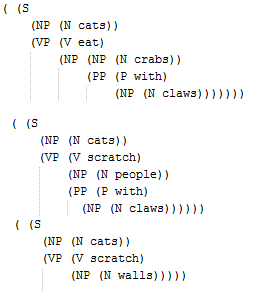

In [11]:
Image(filename='C:\\courses\\coursera\\Past\\NLP\\Stanford_NLP\\Assignment\\pa6-cky-v2\\python\\train1.png', width=400)

The following figure shows the **PCFG** learnt from these training trees. Now let's try to **parse** a single test sentence **'cats scratch walls with claws'** with the **CKY** parser and using the **PCFG** grammar learnt. The following figure shows the manual (**gold**) parse tree and the **best (most probable)** parse tree using the **CKY** *dynamic programming algorithm*. 

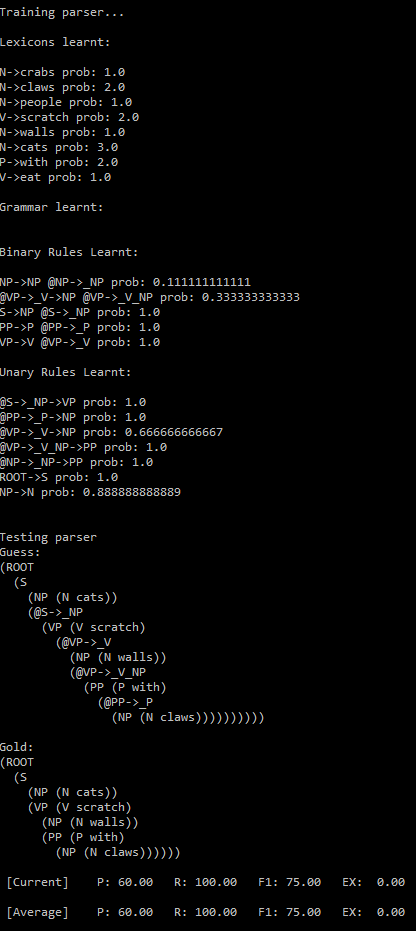

In [14]:
Image(filename='C:\\courses\\coursera\\Past\\NLP\\Stanford_NLP\\Assignment\\pa6-cky-v2\\python\\train2.png', width=600)

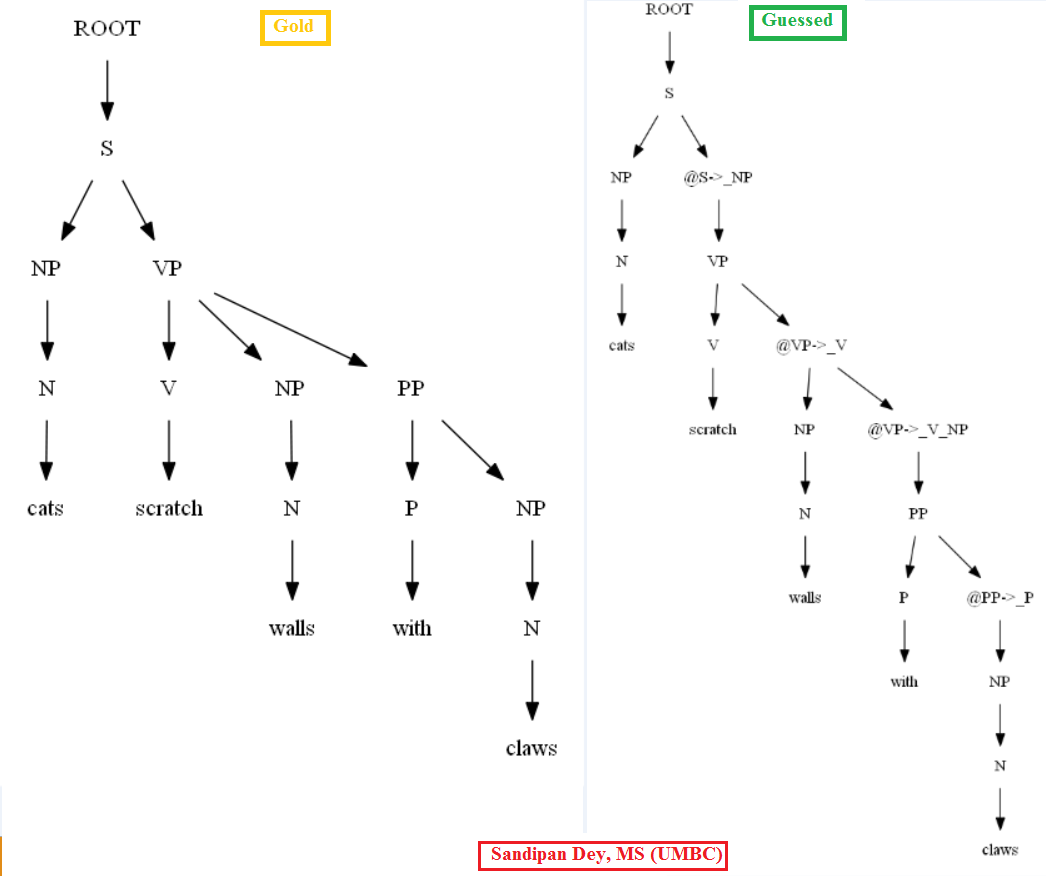

In [16]:
Image(filename='C:\\courses\\coursera\\Past\\NLP\\Stanford_NLP\\Assignment\\pa6-cky-v2\\python\\train3.png')

Now, let's compare the best parse trees obtained with **CKY** (**guessed**) for a few test sentences using **PCFG** learning with a much larger training dataeset with many trees, with the manually (**gold**) parsed trees. 

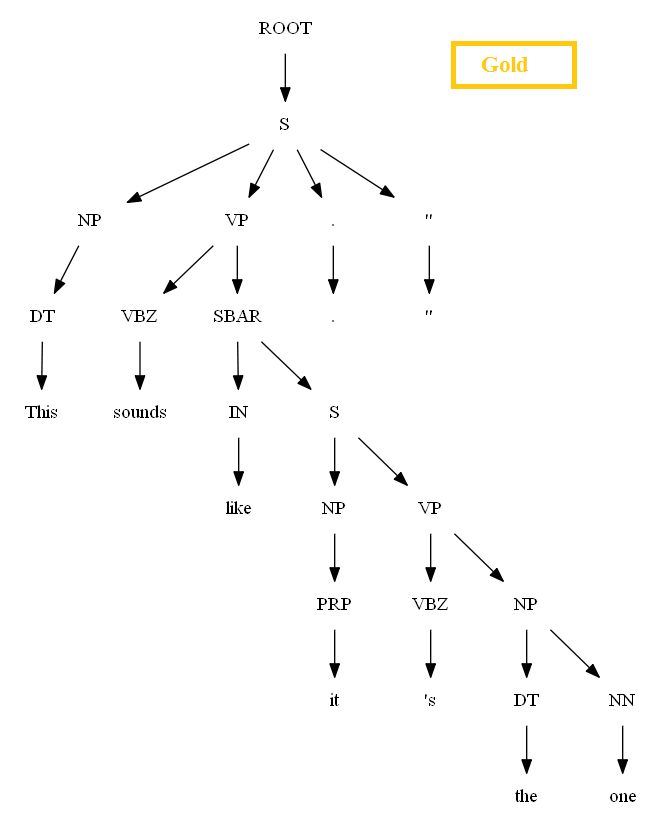

In [18]:
Image(filename='C:\\courses\\coursera\\Past\\NLP\\Stanford_NLP\\Assignment\\pa6-cky-v2\\python\\trees1\\pcfg_gold_Thissoundslikeitsthe.png')

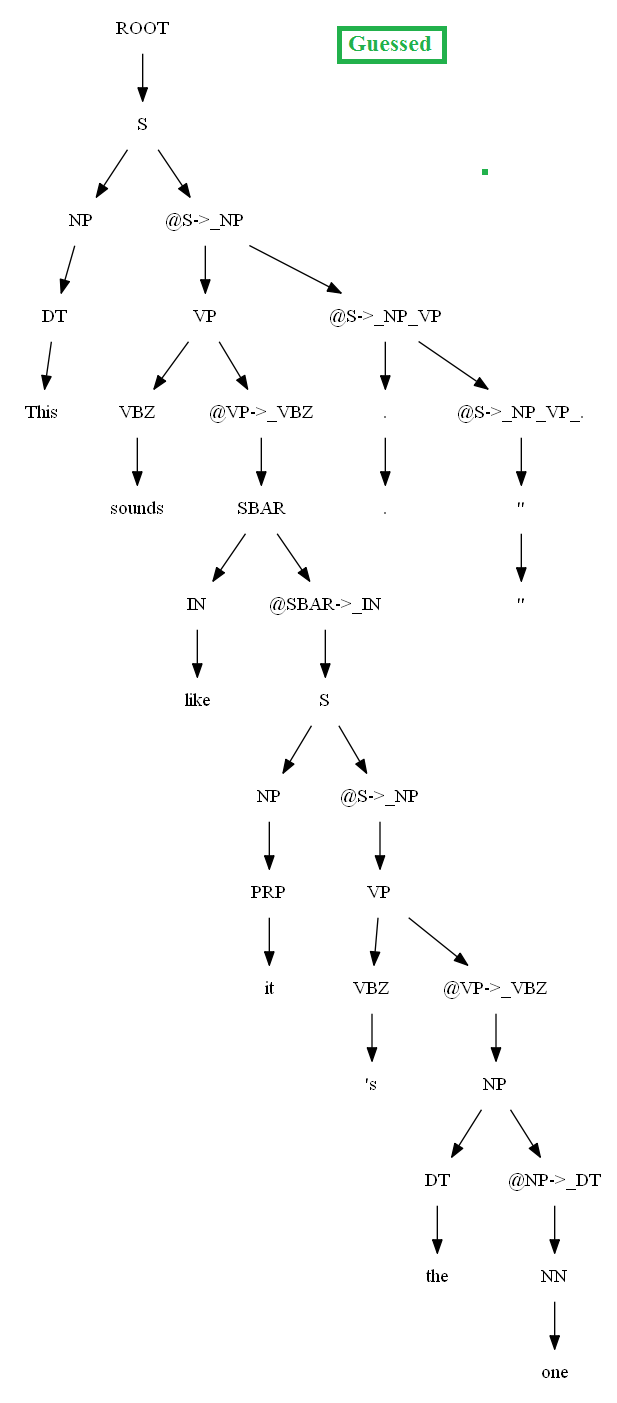

In [19]:
Image(filename='C:\\courses\\coursera\\Past\\NLP\\Stanford_NLP\\Assignment\\pa6-cky-v2\\python\\trees1\\pcfg_guessed_Thissoundslikeitsthe.png')

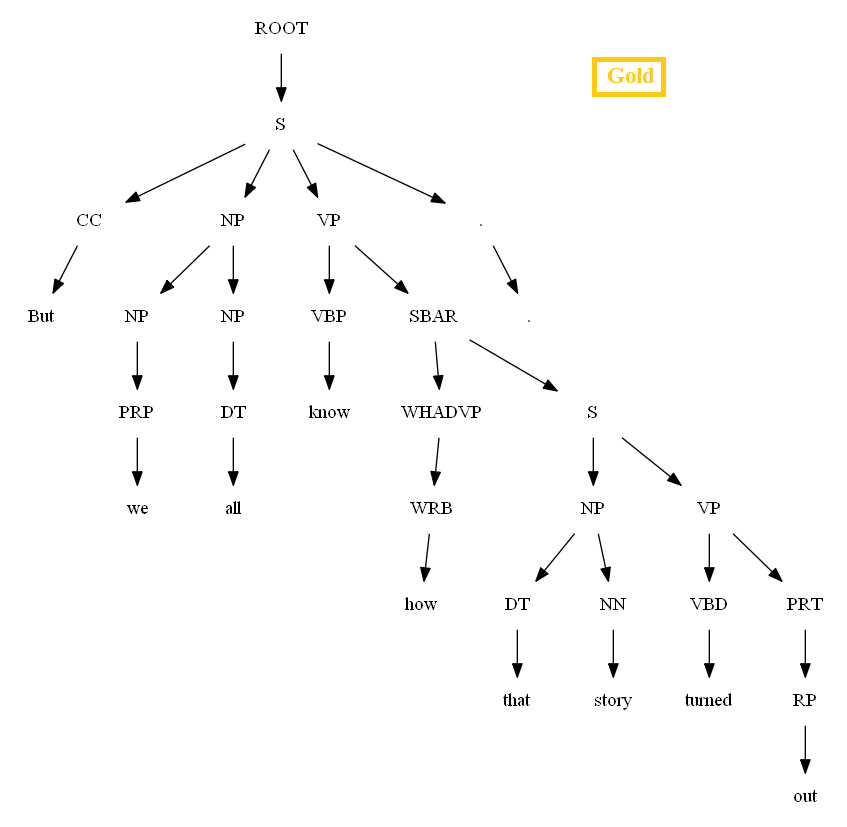

In [20]:
Image(filename='C:\\courses\\coursera\\Past\\NLP\\Stanford_NLP\\Assignment\\pa6-cky-v2\\python\\trees1\\pcfg_gold_Butweallknowhowthat.png')

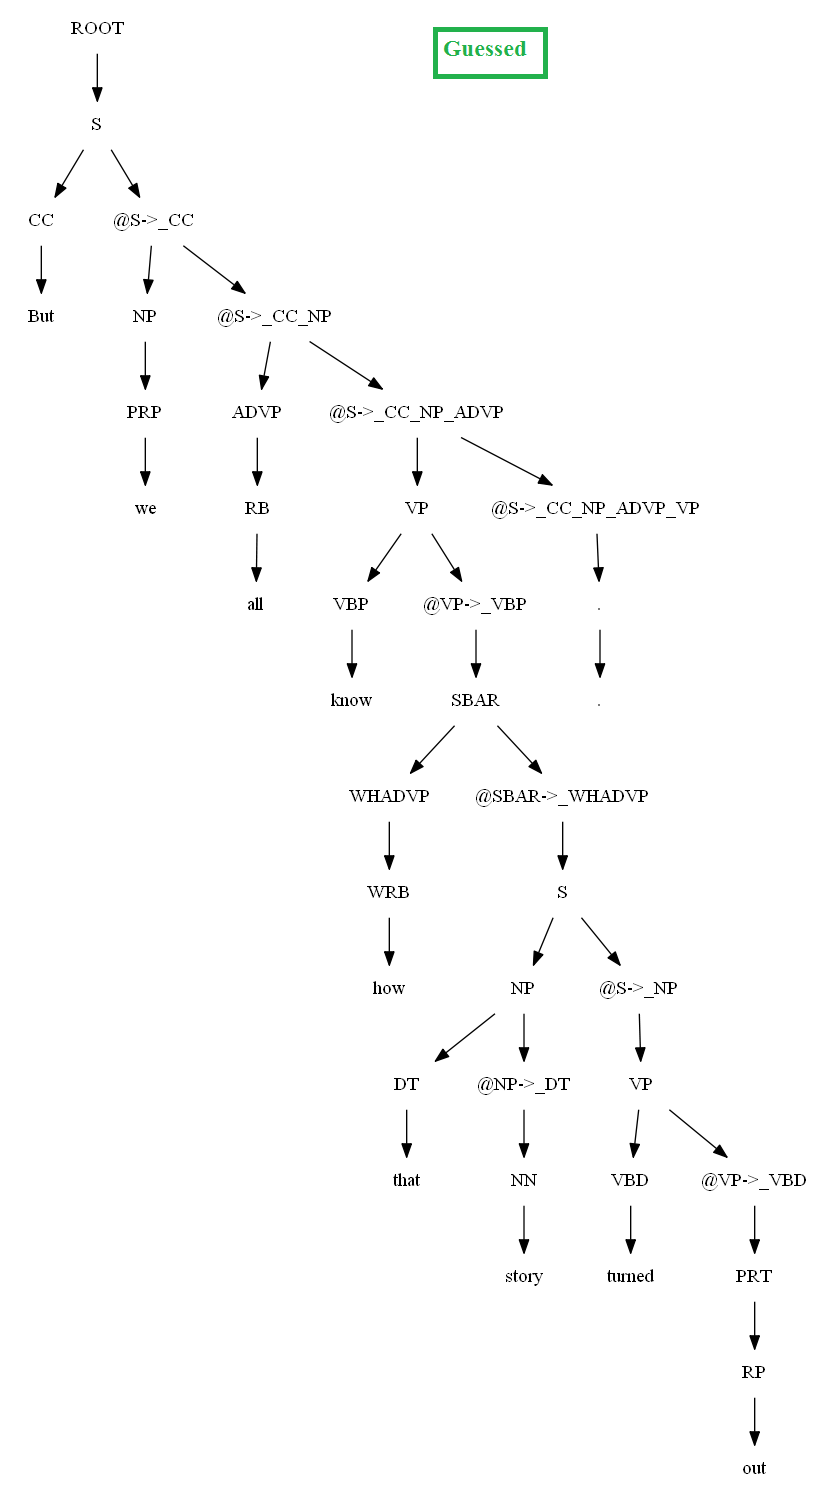

In [21]:
Image(filename='C:\\courses\\coursera\\Past\\NLP\\Stanford_NLP\\Assignment\\pa6-cky-v2\\python\\trees1\\pcfg_guessed_Butweallknowhowthat.png')

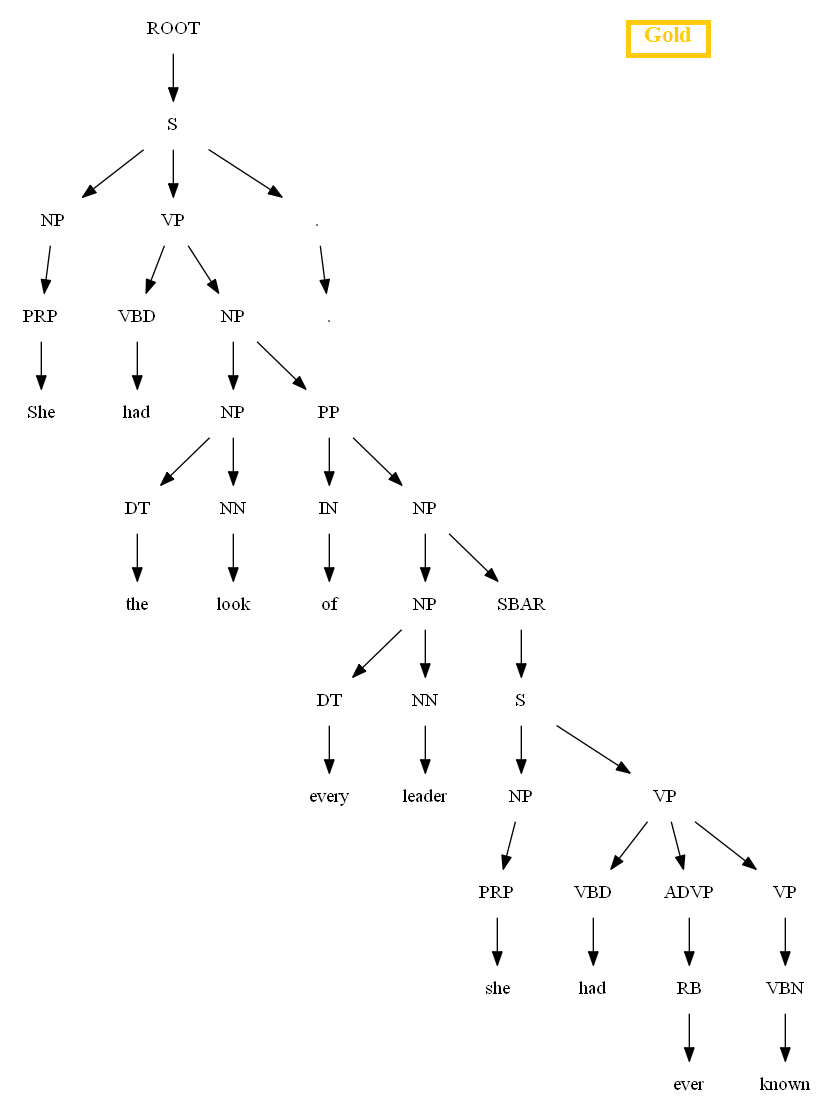

In [22]:
Image(filename='C:\\courses\\coursera\\Past\\NLP\\Stanford_NLP\\Assignment\\pa6-cky-v2\\python\\trees1\\pcfg_gold_Shehadthelookofevery.png')

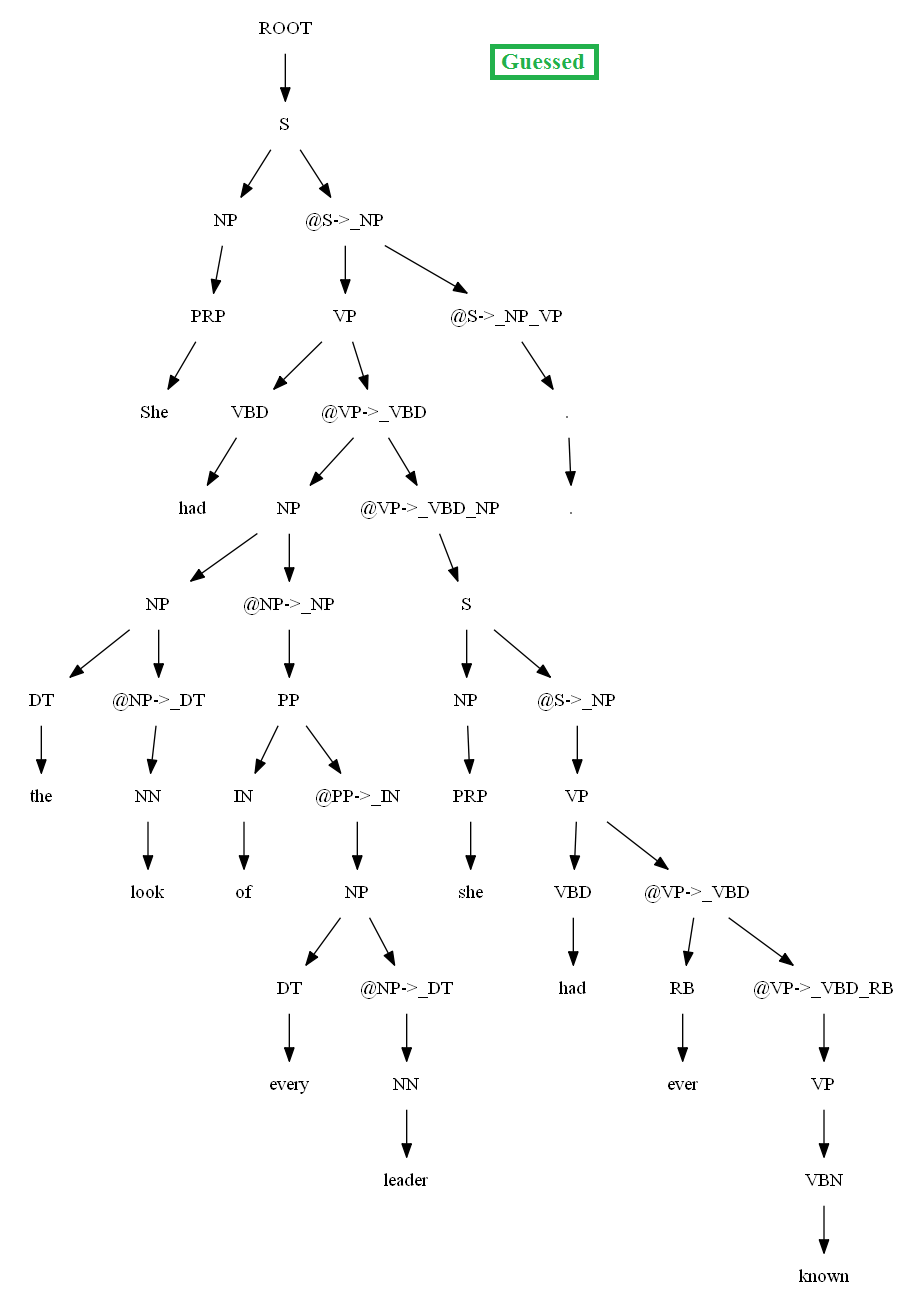

In [23]:
Image(filename='C:\\courses\\coursera\\Past\\NLP\\Stanford_NLP\\Assignment\\pa6-cky-v2\\python\\trees1\\pcfg_guessed_Shehadthelookofevery.png')

## Vertical Markovization
The independence assumptions of a *PCFG* are ofen too strong. In order to indicate the dependency on the parent non-terminal in a tree the grammar rules can be re-written depending on *past k ancestor nodes*, denoting the *order-k vertical Markovization*, as explained in the following figure, which often i.

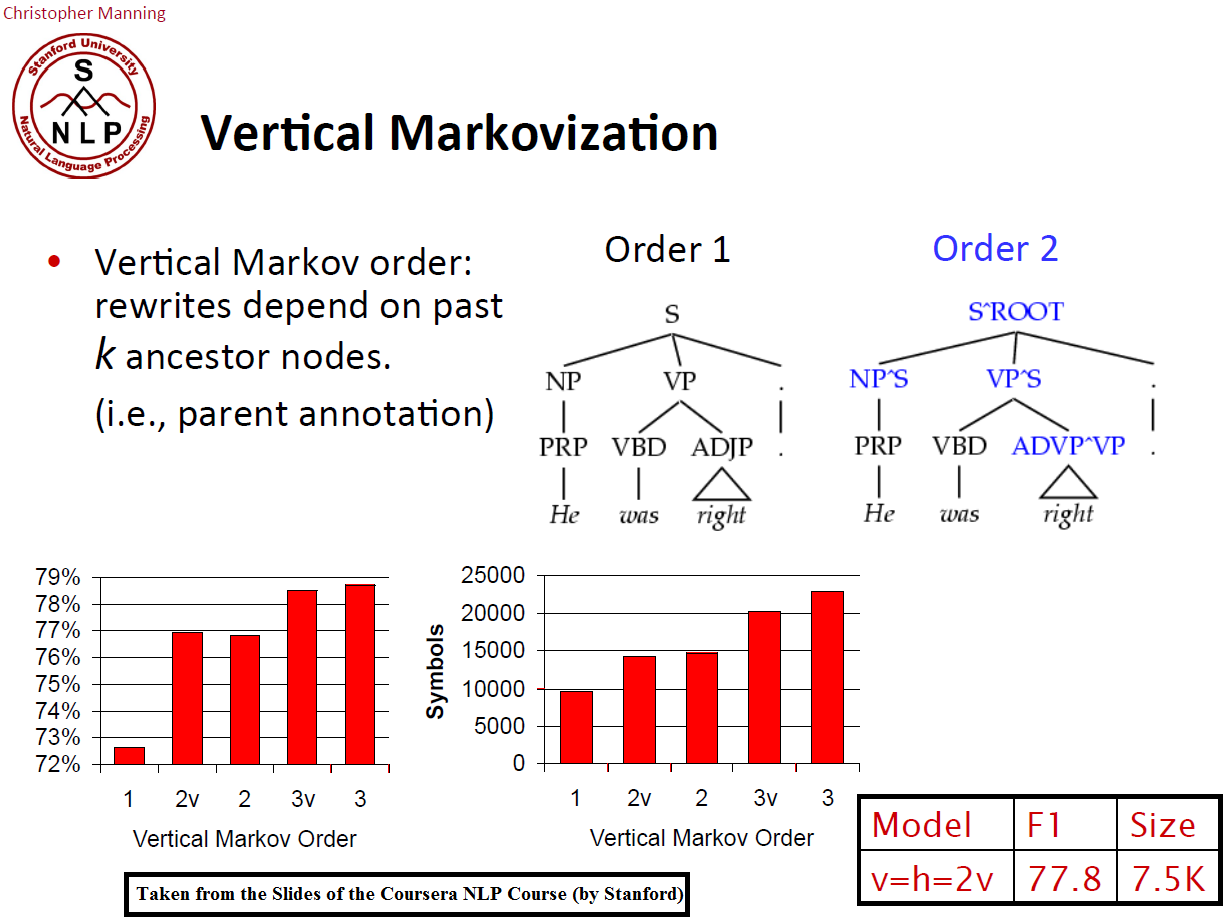

In [25]:
Image(filename='C:\\courses\\coursera\\Past\\NLP\\Stanford_NLP\\Assignment\\pa6-cky-v2\\python\\im2.png')

The following figure shows the **best parse trees** obtained with **CKY** for a sentence using **PCFG** learnt with and without **vertical Markovization**.

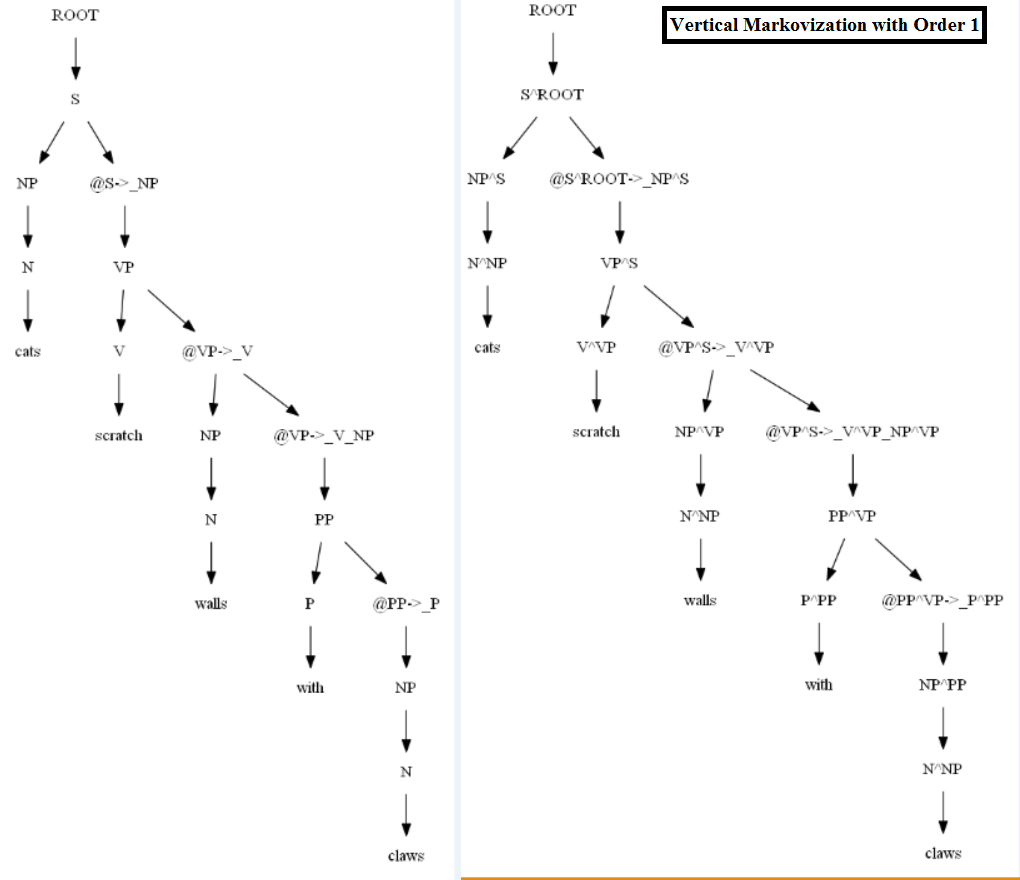

In [27]:
Image(filename='C:\\courses\\coursera\\Past\\NLP\\Stanford_NLP\\Assignment\\pa6-cky-v2\\python\\vmarkov.png')